# Learning Outcomes
This example teaches how to implement k-means clustering algorithm using NumPy and is based on the k-means example in cuNumeric. 

In this example, you will learn:
* how to compute pairwise distances using `newaxis`
* how to "bin" data using the `bincount` 
* how to locate data using `where` and `argmin`
* how to use boolean mask to select data
* how to compute `norm` of an n-dimensional array
* how to determine if two NumPy arrays don't have the same values using `not_equal`.
* how to plot clusters using matplotlib

## Background
To learn more about the clustering algorithm, see [this](https://stanford.edu/~cpiech/cs221/handouts/kmeans.html) material.

## Implementation

In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from typing import Tuple

For reproducibility, use a seed to generate a default random number generator 

In [2]:
# seed the random number generator for deterministic runs
random_seed: int = 42
rng = np.random.default_rng(random_seed)

In [3]:
def initialize(n_elements: int, n_dims: int, n_centroids: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Randomly initalize data and centroids of the clusters.
    
    n_elements: int
        Number of elements/observations that need to be clusters
    n_dims: int
        Dimension of the elements/observations
    n_centroids: int
        Number of clusters

    Returns:
        A Tuple with observations and centroids
    """
    data = rng.random((n_elements, n_dims))
    centroids = rng.random((n_centroids, n_dims))
    return data, centroids

In [4]:
def calculate_distances(data: np.ndarray, centroids: np.ndarray, data_magnitude_squared: np.ndarray) -> np.ndarray:
    """
    Return pairwise distance between the data and centroids.

    data: np.ndarray
        Observations that need to be clustered
    centroids: np.ndarray
        The center of the clusters
    data_magnitude_squared: np.ndarray
        Square of magnitude of observations (|y|^2)

    Returns: np.ndarray
        
    """
    centroid_dots = np.square(np.linalg.norm(centroids, ord=2, axis=1))
    pairwise_distances = ( 
        data_magnitude_squared[:, np.newaxis] + centroid_dots[np.newaxis, :]
    )
    # ||x-y||^2 = ||x||^2 + ||y||^2 - 2 x . y
    # pairwise_distances has ||x||^2 + ||y||^2, so beta = 1
    # The gemm calculates x.y for all x and y, so alpha = -2.0
    pairwise_distances -= 2.0 * np.dot(data, centroids.T)
    return pairwise_distances

In [5]:
def relabel(pairwise_distances: np.ndarray) -> np.ndarray:
    return np.argmin(pairwise_distances, axis=1)

In [6]:
def find_centroids(
    centroids: np.ndarray, 
    data: np.ndarray, 
    labels: np.ndarray, 
    pairwise_distances: np.ndarray,
    zero_point: np.ndarray,
    n_centroids: int
) -> np.ndarray:
    """Find centroids following the algorithm in the reference mentioned earlier
    centroids: np.ndarray
        The center of the clusters
    data: np.ndarray
        Observations that need to be clustered
    labels: np.ndarray
        The clusters the data belong to
    pairwise_distances: np.ndarray
        Pairwise distance between each data point and centroid
    zero_point: np.ndarray
        
    n_centroids: np.ndarray
        Number of clusters
    """
    # Get the number of points associated with each centroid
    counts = np.bincount(labels, minlength=n_centroids)
    # Build label masks for each centroid and sum across all the
    # points assocated with each new centroid
    distance_sum = 0.0 
    for idx in range(n_centroids):
        # Boolean mask indicating where the points are for this center
        centroid_mask = labels == idx 
        centroids[idx, :] = np.sum(
            np.where(centroid_mask[..., np.newaxis], data, zero_point), axis=0
        )   
        distance_sum += np.sum(
            np.where(centroid_mask, pairwise_distances[:, idx], 0.0)
        )   
    # To avoid introducing divide by zero errors
    # If a centroid has no weight, we'll do no normalization
    # This will keep its coordinates defined.
    counts = np.maximum(counts, np.ones((1,), dtype=np.uint64))
    centroids /= counts[:, np.newaxis]
    return distance_sum

In [7]:
def run_kmeans(
    n_centroids: int,
    n_dims: int, 
    n_iters: int, 
    n_elements: int, 
    n_iter_check: int
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """ 
    Generate observations and cluster them into requested number of clusters.
    n_centroids: int
        Number of clusters
    n_dims: int
        Dimension of the elements/observations
    n_iters: int
        Maximum number of iterations        
    n_elements: int
        Number of elements/observations that need to be clusters
    n_iter_check: int
        Determines how often we check for convergence.
    """
    print("Running kmeans...")
    print("Number of data points: " + str(n_elements))
    print("Number of dimensions: " + str(n_dims))
    print("Number of centroids: " + str(n_centroids))
    print("Max iterations: " + str(n_iters))

    data, centroids = initialize(n_elements, n_dims, n_centroids)

    data_magnitude_squared = np.square(np.linalg.norm(data, ord=2, axis=1))
    zero_point = np.zeros((1, data.shape[1]), dtype=data.dtype)

    labels = None
    iteration = 0 
    prior_distance_sum = None
    # We run for max iterations or until we converge
    # We only test convergence every n_iter_check iterations
    while iteration < n_iters:
        pairwise_distances = calculate_distances(data, centroids, data_magnitude_squared)

        new_labels = relabel(pairwise_distances)

        distance_sum = find_centroids(
            centroids,
            data,
            new_labels,
            pairwise_distances,
            zero_point,
            n_centroids,
        )   

        if iteration > 0 and iteration % n_iter_check == 0:
            changes = np.not_equal(labels, new_labels)
            total_changes = np.sum(changes)
            delta = distance_sum / prior_distance_sum
            if delta > 1 - 0.000001:
                break
                
        prior_distance_sum = distance_sum
        labels = new_labels
        iteration += 1

    return data, labels, centroids

### Lets run the kmeans algorithm using a set of inputs

In [8]:
n_centroids: int = 5
n_dims: int = 2
n_elements: int = 256
n_iter_check: int = 10
n_iters: int = 100

data, labels, centroids = run_kmeans(n_centroids, n_dims, n_iters, n_elements, n_iter_check)

Running kmeans...
Number of data points: 256
Number of dimensions: 2
Number of centroids: 5
Max iterations: 100


Generate a color map to differentiate the clusters

In [9]:
label_color_map = {0: 'blue', 1: 'black', 2: 'red', 3: 'magenta', 4:'yellow', 5: 'green', 6:'gray'}

# make sure we have unique color for each cluster (total number of clusters specified by n_centroids)
assert len(label_color_map.items()) >= n_centroids

Plot the clusters. Each color represents a cluster

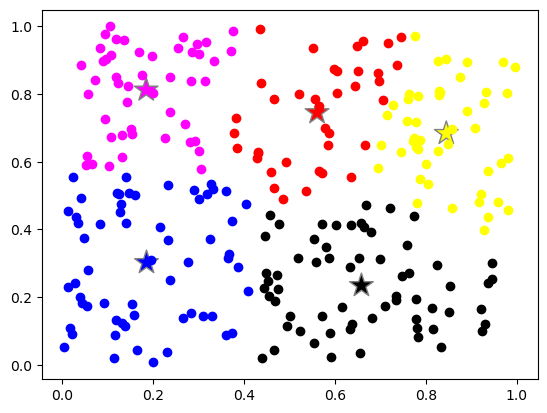

In [10]:
# lets plot the data colored by the cluster they belong to
for label_value, label_color in label_color_map.items():
    index = (labels == label_value)
    plt.plot(data[index, 0], data[index, 1], 'o', color=label_color)

# lets plot the centroid of the clusters
plt.scatter(centroids[:, 0], centroids[:, 1], s = 320, marker='*', c=list(label_color_map.values())[0:n_centroids], edgecolors='gray');

plt.show()

#### Exercise: Change the number of clusters and number of observations and see how the clusters change